<img src="images/mcg.jpg", style="width: 100px">


# Gaussian Bayesian Networks (GBNs)

## Generate $x_1$ $x_2$ and $Y$ from a Multivariate Gaussian Distribution with a Mean and a Variance.

What if the inputs to the linear regression were correlated? This often happens in linear dynamical systems. Linear Gaussian Models are useful for modeling probabilistic PCA, factor analysis and linear dynamical systems. Linear Dynamical Systems have variety of uses such as tracking of moving objects. This is an area where Signal Processing methods have a high overlap with Machine Learning methods. When the problem is treated as a state-space problem with added stochasticity, then the future samples depend on the past. The latent parameters, $\beta_i$ where $i \in [1,...,k]$ provide a linear combination of the univariate gaussian distributions as shown in the figure. 

<img src="images/gbn.png", style="width: 400px">

The observed variable, $y_{jx}$ can be described as a sample that is drawn from the conditional distribution:

$$\mathcal{N}(y_{jx} | \sum_{i=1}^k \beta_i^T x_i + \beta_0; \sigma^2)$$

The latent parameters $\beta_is$ and $\sigma^2$ need to be determined. 

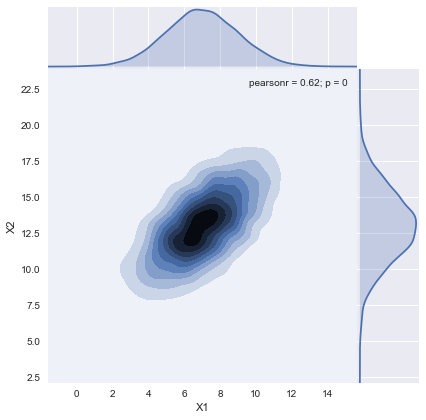

In [1]:
#### import numpy as np
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from matplotlib import pyplot

# Obtain the X and Y which are jointly gaussian from the distribution
mu_x = np.array([7, 13])
sigma_x = np.array([[4 , 3],
                    [3 , 6]])

# Variables
states = ['X1', 'X2']
all_states = ['X1', 'X2', 'P_X']
sym_coefs = ['b1_coef', 'b2_coef']

# Generate samples from the distribution
X_Norm = multivariate_normal(mean=mu_x, cov=sigma_x)
X_samples = X_Norm.rvs(size=10000)
X_df = pd.DataFrame(X_samples, columns=states)

# Generate 
X_df['P_X'] = X_df.apply(X_Norm.pdf, axis=1)
X_df.head()

g = sns.jointplot(X_df['X1'], X_df['X2'], kind="kde", height=10, space=0)

## Linear Gaussian Models - The Process

The linear gaussian model in supervised learning scheme is nothing but a linear regression where inputs are drawn from a jointly gaussian distribution. 

Determining the Latent Parameters via Maximum Likelihood Estimation (MLE)

The samples drawn from the conditional linear gaussian distributions are observed as:

$$ p(Y|X) = \cfrac{1}{\sqrt(2\pi\sigma_c^2} \times exp(\cfrac{(\sum_{i=1}^k \beta_i^T x_i + \beta_0 - x[m])^2}{2\sigma^2})$$

Taking log,

$$ log(p(Y|X)) = (\sum_{i=1}^k[-\cfrac{1}{2}log(2\pi\sigma^2) - \cfrac{1}{2\sigma^2}( \beta_i^T x_i + \beta_0 - x[m])^2)]$$

Differentiating w.r.t $\beta_i$, we can get k+1 linear equations as shown below:


### The Condtional Distribution p(Y|X)

<img src="images/lgm.png", style="width: 700px">

The betas can easily be estimated by inverting the coefficient matrix and multiplying it to the right-hand side.

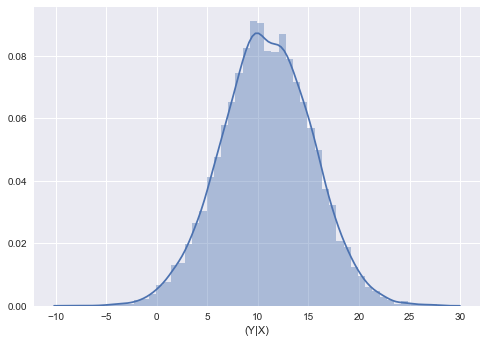

In [2]:
beta_vec = np.array([.7, .3])
beta_0 = 2
sigma_c = 4

def genYX(x):
    '''
    Generates samples distributed according to Gaussian Normal Distributions.
    Args:
        x (row): Dataframe row 
    Returns:
        (float): Sample distributed as Gaussian
        
    '''
    x = [x['X1'], x['X2']]
    var_mean = np.dot(beta_vec.transpose(), x) + beta_0
    Yx_sample = np.random.normal(var_mean, sigma_c, 1)
    return Yx_sample[0]

X_df['(Y|X)'] = X_df.apply(genYX, axis=1)
X_df.head()

sns.distplot(X_df['(Y|X)'])

# Determine parameters $\beta_0, \beta_1, \beta_2$ using Maximum Likelihood Estimation (MLE)


In [3]:
x_len = len(states)

def exp_value(xi, xj):
    '''
    Computes sum of product of two columns of a dataframe.
    Args:
        xi (column): Column of a dataframe
        xj (columns): Column of a dataframe
    Returns:
        (float): Sum of product of two columns
        
    '''
    prod_xixj = xi*xj
    return np.sum(prod_xixj)

sum_X = X_df.sum()
X = [sum_X['(Y|X)']]
print(sum_X)
print(X)
coef_matrix = pd.DataFrame(columns=sym_coefs)

# First we compute just the coefficients of beta_1 to beta_N. 
# Later we compute beta_0 and append it.
for i in range(0, x_len):
    X.append(exp_value(X_df['(Y|X)'], X_df[states[i]]))

    for j in range(0, x_len):
        coef_matrix.loc[i, sym_coefs[j]] = exp_value(X_df[states[i]], X_df[states[j]])

coef_matrix.insert(0, 'b0_coef', sum_X.values[0:x_len])
row_1 = np.append([len(X_df)], sum_X.values[0:x_len])
coef_matrix.loc[-1] = row_1 
coef_matrix.index = coef_matrix.index + 1  # shifting index
coef_matrix.sort_index(inplace=True) 

# Compute beta values
# https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-GaussianBNs/8.5%20GaussianBNs.pdf
beta_coef_matrix = np.matrix(coef_matrix.values, dtype='float')
coef_inv = np.linalg.inv(beta_coef_matrix)
beta_est = np.array(np.matmul(coef_inv, np.transpose(X)))
beta_est = beta_est[0]
print(beta_est)

X1        69918.010451
X2       130299.276978
P_X         204.871304
(Y|X)    108661.717678
dtype: float64
[108661.7176775265]
[ 2.02252097  0.72858582  0.28776243]


This retrieves the beta parameters. Feel free to use the notebook/images for commerical/non-commercial purpose as long as you have the logos in place.

## Estimating Variance

$$\sigma^2 = cov[y;y] - \sum_i \sum_j \beta_i \beta_j Cov_D[X_i;X_j]$$

In [4]:
# First we compute just the coefficients of beta_1 to beta_N. 
# Later we compute beta_0 and append it.
sigma_est = 0
M = len(X_df)
for i in range(0, x_len):
    for j in range(0, x_len):
        sigma_est += beta_est[i+1]*beta_est[j+1]*(exp_value(X_df[states[i]], X_df[states[j]])/M - np.mean(X_df[states[i]])*np.mean(X_df[states[j]]))

# Estimate Variance
sigma_est = np.sqrt(exp_value(X_df['(Y|X)'], X_df['(Y|X)'])/M - np.mean(X_df['(Y|X)'])*np.mean(X_df['(Y|X)']) - sigma_est)
print(sigma_est)

4.00312173927



For any questions feel free to contact hkashyap [at] icloud.com. Thanks to Praveen Kaushik for the diagrams(diagram.ai), Kiran Byadarhaly and Karthik Chandrashekhar for proof reading the math.